In [1]:
!nvidia-smi

Thu Apr 25 22:34:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              25W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install Detectron2 and dependencies

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Now is a good time to confirm that we have the right versions of the libraries at our disposal.

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
torch:  2.1 ; cuda:  2.1.2
detectron2: 0.6


In [4]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime


# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

import matplotlib.pyplot as plt

## COCO Format Dataset

### Download

We use `football-pitch-segmentation` dataset as example. Feel free to visit [Roboflow Universe](https://universe.roboflow.com/), and select any other Instance Segmentation dataset. Make sure to download the dataset in correct - `COCO Segmentation` format.

Structure of your dataset should look like this:

```
dataset-directory/
├─ README.dataset.txt
├─ README.roboflow.txt
├─ train
│  ├─ train-image-1.jpg
│  ├─ train-image-1.jpg
│  ├─ ...
│  └─ _annotations.coco.json
├─ test
│  ├─ test-image-1.jpg
│  ├─ test-image-1.jpg
│  ├─ ...
│  └─ _annotations.coco.json
└─ valid
   ├─ valid-image-1.jpg
   ├─ valid-image-1.jpg
   ├─ ...
   └─ _annotations.coco.json
```

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="EXAMPLE API")
project = rf.workspace("WORKSPACE FOLDER").project("PROJECT NAME")
version = project.version(2)
dataset = version.download("coco")


### Register

When you use Detectron2, before you actually train the model you need to [register it](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#register-a-coco-format-dataset).

In [6]:
DATA_SET_NAME = dataset.name.replace(" ", "-")
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

In [7]:
# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME,
    metadata={},
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH,
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "test")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME,
    metadata={},
    json_file=TEST_DATA_SET_ANN_FILE_PATH,
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME,
    metadata={},
    json_file=VALID_DATA_SET_ANN_FILE_PATH,
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

In [ ]:
[
    data_set
    for data_set
    in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

### Visualize

Let's take a look at single entry from out train dataset.

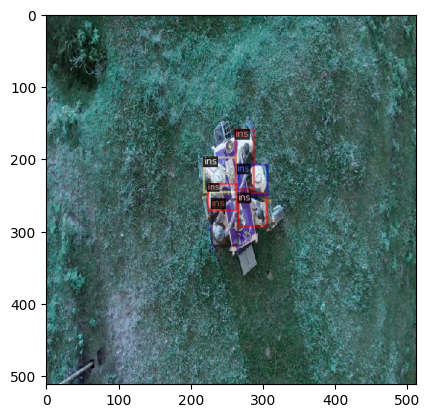

In [9]:
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[0]
image = cv2.imread(dataset_entry["file_name"])

visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata,
    scale=0.8,
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
plt.imshow(out.get_image()[:, :, ::-1])

## Train Model Using Custom COCO Format Dataset

### Configuration

In [10]:
# HYPERPARAMETERS
ARCHITECTURE = "retinanet_R_101_FPN_3x"
CONFIG_FILE_PATH = f"COCO-Detection/{ARCHITECTURE}.yaml"
MAX_ITER = 10000
EVAL_PERIOD = 500
BASE_LR = 0.001
NUM_CLASSES = 14

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME,
    ARCHITECTURE,
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [11]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.RETINANET.NUM_CLASSES = NUM_CLASSES
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

In [12]:
cfg.MODEL.ROI_HEADS.NUM_CLASSES

14

### Training

In [13]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

model_final_971ab9.pkl: 228MB [00:01, 176MB/s]                           
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
2024-04-25 22:38:37.901832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 22:38:37.901938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 22:38:38.043818: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
# Look at training curves in tensorboard:
#%load_ext tensorboard
#%tensorboard --logdir $OUTPUT_DIR_PATH

### Evaluation

In [15]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

  0%|          | 0/2691 [00:00<?, ?it/s]

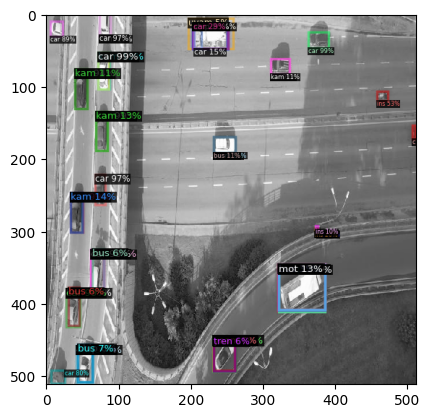

  0%|          | 1/2691 [00:00<40:09,  1.12it/s]

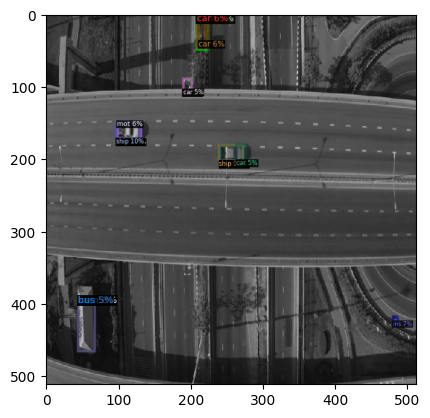

  0%|          | 2/2691 [00:01<31:24,  1.43it/s]

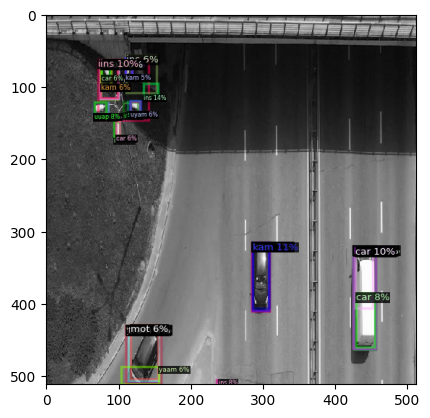

  0%|          | 3/2691 [00:02<32:05,  1.40it/s]

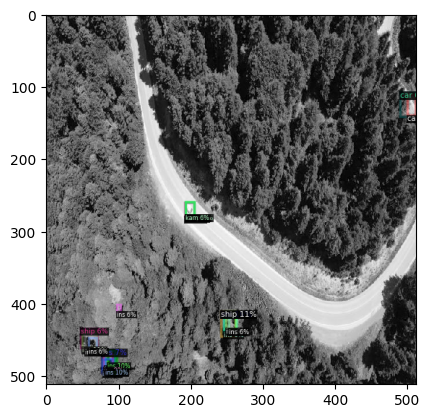

  0%|          | 4/2691 [00:02<30:11,  1.48it/s]

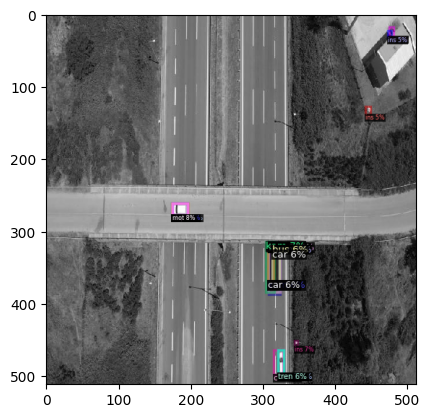

  0%|          | 5/2691 [00:03<29:03,  1.54it/s]

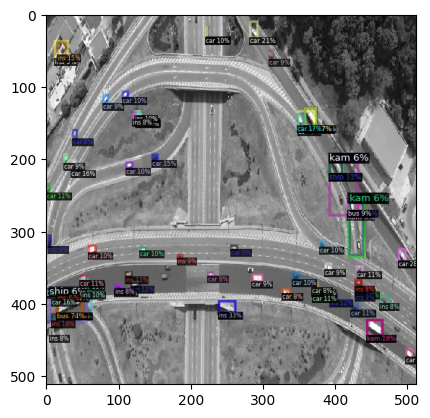

  0%|          | 6/2691 [00:04<32:17,  1.39it/s]

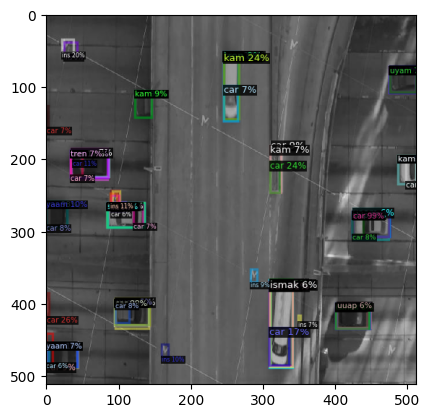

  0%|          | 7/2691 [00:05<36:08,  1.24it/s]

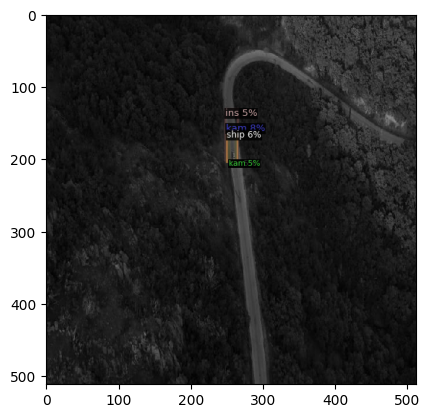

  0%|          | 8/2691 [00:05<32:01,  1.40it/s]

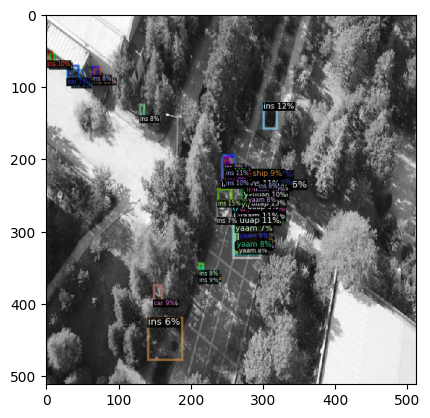

  0%|          | 9/2691 [00:07<41:27,  1.08it/s]

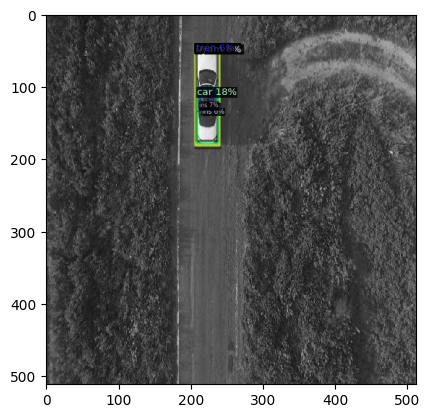

  0%|          | 10/2691 [00:07<34:27,  1.30it/s]


In [16]:
from tqdm import tqdm

dataset_valid = DatasetCatalog.get(VALID_DATA_SET_NAME)
i = 0
for d in tqdm(dataset_valid):
    if i < 10:
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)

        visualizer = Visualizer(
            img[:, :, ::-1],
            metadata=metadata,
            scale=0.8,
            instance_mode=ColorMode.IMAGE_BW
        )
        out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.imshow(out.get_image()[:, :, ::-1])
        plt.show()  # Show the image for each iteration
        i+=1
    else:
        break
